# Projet Optimisation

## Introduction
L’objectif de ce travail est d’implémenter un modèle de régression logistique à partir d’un échantillon expérimental choisi parmi des données disponibles sur le web. L'objectif est de calculer les coefficients $\beta_0$ et $\beta_1$ du modèle en utilisant un algorithme d'optimisation, tel que la descente de gradient ou la méthode de Newton et faire la comparaison des résultats donnés par un toolbox.

## Dataset
* <b> Source : </b> https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset
* <b> Description : </b> Ce dataset contient des informations sur des personnes, telles que leur sexe, âge, profession, et des données sur leur sommeil, leur activité physique, leur stress, et leur santé. Il inclut des mesures comme la durée du sommeil, la qualité du sommeil, le niveau d'activité physique, le stress, l'indice de masse corporelle (IMC), la pression artérielle, la fréquence cardiaque et le nombre de pas quotidiens. La colonne "Sleep Disorder" indique si la personne souffre d'un trouble du sommeil, comme l'apnée du sommeil ou l'insomnie. Ce dataset permet d'étudier l'impact de ces facteurs sur la qualité du sommeil.
  


In [64]:
import pandas as pd

df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
print(df.head())

   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200            NaN  
1         125/80          75      

## <b> Choix des variables : </b>
### <b> La Varible Binaire : </b>  
La variable  <b> Sleep Disorder Binary </b> indique si une personne a un trouble du sommeil ou non. Elle prend la valeur 1 si la personne a un trouble du sommeil (Insomnia ou Sleep Apnea) et 0 si elle n'en a pas (NaN).
### <b> La Varible Explicative : </b>  
Bien qu'il y ait plusieurs variables explicatives potentielles dans le dataset, telles que Sleep Duration, Stress Level, BMI Category, etc., nous avons choisi de nous concentrer uniquement sur la variable <b> Physical Activity Level</b>. Cette variable représente le niveau d'activité physique de la personne et est utilisée pour évaluer son impact potentiel sur les troubles du sommeil.



>### Standardisation des données 
>Avant de commencer l'analyse, j'ai standardisé la variable <b> Physical Activity Level </b>. La standardisation permet de centrer et réduire les données, c'est-à-dire les ajuster pour qu'elles aient une moyenne de 0 et un écart-type de 1. Cela aide à éviter que des variables avec des échelles différentes n'affectent de manière disproportionnée le modèle.
Dans ce cas, j'ai utilisé l'outil StandardScaler de scikit-learn pour cette étape.



In [65]:
import numpy as np
from sklearn.preprocessing import StandardScaler

#standardisation des données
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df[['Physical Activity Level']])

# la vaiable binaire 
df["Sleep Disorder Binary"] = df["Sleep Disorder"].apply(lambda x: 1 if x in ["Sleep Apnea", "Insomnia"] else 0)
y = df["Sleep Disorder Binary"].values

#la variable explicative
x = x_scaled
x = x.reshape(-1, 1)
# Devant chaque valeur de la variable x on a ajouté 1 (nous permet de calculer beta 0 le biais)
x = np.c_[np.ones(x.shape[0]), x]
#print(x)

## Division des données 
J'ai divisé les données en deux parties égales : une moitié pour entraîner le modèle et l'autre moitié pour le tester. Cela permet d'évaluer la performance du modèle sur des données qu'il n'a pas vues pendant l'entraînement. 

In [66]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

## Implémentation du Modèle de Régression Logistique

### 1. Modèle de Régression Logistique

Le modèle de régression logistique est utilisé pour prédire la probabilité qu'un événement se produise, basé sur une ou plusieurs variables explicatives. La probabilité 
$ P(y=1 ∣x ) $ d'une observation x (qui peut être une ou plusieurs caractéristiques) est donnée par la fonction logistique :
$$ P(y = 1 | x) = g(\beta_0 + \beta_1x) \quad avec \quad g(z) = \frac{1}{1 + e^{-z}} $$
qui est la fonction sigmoïde qui transforme les valeurs linéaires en probabilités entre 0 et 1.

### 2. Fonction de Log-Vraisemblance

La fonction de log-vraisemblance mesure la qualité du modèle en comparant les prédictions du modèle aux valeurs réelles. Elle est maximisée pour obtenir les meilleurs paramètres $ \beta_0 $ et $ \beta_1 $. La fonction de log-vraisemblance pour un ensemble d'observations $ (x_i, y_i) $ est donnée par :


$$ l(β) ≡ \ln L(β) = \sum_{i=1}^{N} \left( y_i \ln p(x_i) + (1 - y_i) \ln [1 - p(x_i)] \right) $$

où $ p(x_i) $ est la probabilité prédite par le modèle de régression logistique pour chaque observation $ x_i $, et $ y_i $ est la valeur réelle pour cette observation.



In [67]:
# la fonction de régression logistique 
def g(z):
    #return np.exp(z) / ( 1 + np.exp(z) )
    return 1 / (1 + np.exp(-np.clip(z, -500, 500))) # to prevent overlfow error
def régression_logistique(x, beta):
    z = np.dot(x,beta)
    return g(z)

#la fonction de log-vraisemblance
def log_vraisemblance(x, y, beta):
    prédiction = régression_logistique(x, beta)
    prédiction = np.clip(prédiction, 1e-10, 1 - 1e-10)
    value = np.sum(y * np.log(prédiction) + (1 - y) * np.log(1 - prédiction))
    return value

## Méthodes d'optimisation
### 1. Descente de gradient
La descente de gradient est une méthode itérative utilisée pour optimiser les paramètres $ \beta_0 $ et $ \beta_1 $ du modèle de régression logistique. L'objectif est de minimiser la fonction de log-vraisemblance en ajustant progressivement les coefficients.

Les coefficients $ \beta_j $ sont mis à jour selon la règle suivante :

$$ \beta_j \leftarrow \beta_j - \eta \frac{\partial l}{\partial \beta_j}, \quad j = 0, 1 $$

- $ \beta_j $ représente les coefficients du modèle (ici, $ \beta_0 $ et $ \beta_1 $).
- $ \eta $ est le taux d'apprentissage ( learning rate), un paramètre qui contrôle la taille des pas dans le processus d'optimisation.
- $ \frac{\partial l}{\partial \beta_j} $ est la dérivée partielle de la fonction de log-vraisemblance par rapport à $ \beta_j $.

Cette règle permet d'ajuster les coefficients du modèle dans la direction opposée au gradient de la fonction de log-vraisemblance, ce qui conduit à la minimisation de cette fonction au fil des itérations.


In [68]:
#la fonction de descente de gradient 
def gradient(x, y, beta):
    prediction = régression_logistique(x, beta)
    error = prediction - y
    grad = np.dot(x.T, error)  
    return grad
    
def gradient_descent(x, y, beta_init, learning_rate, iterations):
    beta = beta_init
    log_likelihoods = []
    for i in range(iterations):
        grad = gradient(x, y, beta)
        beta -= learning_rate * grad 
        log_likelihoods.append(log_vraisemblance(x, y, beta))
    return beta, log_likelihoods

beta_init = np.zeros(x.shape[1])
beta_gd, log_likelihoods_gd = gradient_descent(x_train, y_train, beta_init, learning_rate=0.01, iterations=1000)
print(f"Gradient Descent Beta: {beta_gd}")
#print(type(beta_gd))
#print(beta_gd[0])

Gradient Descent Beta: [-0.49302275  0.03786406]


### 2. Méthode de Newton
La méthode de Newton est une autre méthode d'optimisation utilisée pour estimer les coefficients $ \beta_0 $ et $ \beta_1 $ dans la régression logistique. Contrairement à la descente de gradient, la méthode de Newton utilise une approximation quadratique de la fonction de log-vraisemblance pour ajuster les coefficients de manière plus rapide et plus efficace.

Les coefficients sont mis à jour selon la règle suivante :

$$ \beta \leftarrow \beta - Hl^{-1} \nabla l $$

- $ \beta $ représente les coefficients du modèle ($ \beta_0 $ et $ \beta_1 $).
- $ \nabla l $ est le gradient de la fonction de log-vraisemblance, qui est un vecteur contenant les dérivées partielles par rapport à chaque paramètre.
- $ H $ est la matrice hessienne de la fonction de log-vraisemblance, qui est une matrice carrée contenant les dérivées secondes par rapport aux paramètres.
- $ H^{-1} $ est l'inverse de la matrice hessienne.

La méthode de Newton utilise à la fois le gradient (première dérivée) et la matrice hessienne (deuxième dérivée) pour effectuer des ajustements plus rapides et plus précis des coefficients. Cette approche permet de converger plus rapidement vers les valeurs optimales des paramètres par rapport à la descente de gradient.


In [69]:
#la fonction de Newton
def hessian(x, beta):
    prediction = régression_logistique(x, beta)
    diag = prediction * (1 - prediction)
    return np.dot(x.T, diag[:, None] * x)

def newton_method(x, y, beta_init, iterations):
    beta = beta_init
    log_likelihoods = []
    for i in range(iterations):
        grad = gradient(x, y, beta)
        H = hessian(x, beta)
        #H += np.eye(H.shape[0]) * 1e-4
        beta -= np.linalg.inv(H).dot(grad)
        log_likelihoods.append(log_vraisemblance(x, y, beta))
    return beta, log_likelihoods

beta_init = np.zeros(x.shape[1])
beta_newton, log_likelihoods_newton  = newton_method(x_train, y_train, beta_init, iterations=1000)
print(f"Gradient Descent Beta: {beta_newton}")

Gradient Descent Beta: [-0.49302275  0.03786406]


### 3. Comparaison des 2 méthodes 
La méthode de Newton converge généralement plus rapidement que la descente de gradient grâce à l'utilisation de la matrice hessienne, ce qui permet des ajustements plus précis des coefficients à chaque itération. Cela se reflète dans les graphiques de log-vraisemblance, où Newton atteint rapidement un plateau, tandis que la descente de gradient a une convergence plus lente et dépend fortement du taux d'apprentissage.



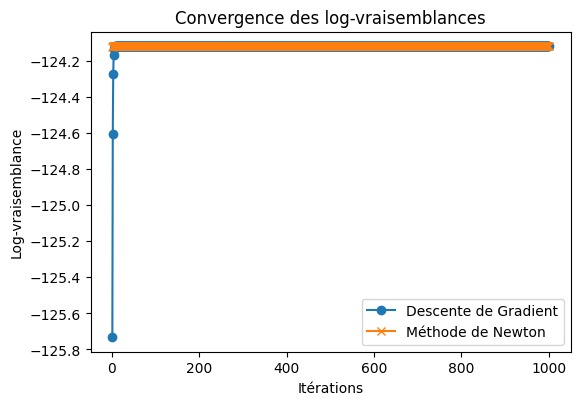

In [70]:
import matplotlib.pyplot as plt

# Graphiques de convergence des log-vraisemblances
iterations = np.arange(1, len(log_likelihoods_gd) + 1)
plt.figure(figsize=(6,4 ))
plt.plot(iterations, log_likelihoods_gd, label='Descente de Gradient', marker='o')
plt.plot(iterations, log_likelihoods_newton, label='Méthode de Newton', marker='x')
plt.xlabel('Itérations')
plt.ylabel('Log-vraisemblance')
plt.title('Convergence des log-vraisemblances')
plt.legend()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()



la performance de la descente de gradient dépend fortement du taux d'apprentissage (learning rate), qui contrôle la taille des mises à jour des coefficients à chaque itération.

* Taux d'apprentissage trop petit : les mises à jour sont trop petites, ce qui ralentit la convergence et peut nécessiter un grand nombre d'itérations pour atteindre un minimum local.
* Taux d'apprentissage trop grand : les mises à jour peuvent être trop importantes, ce qui peut faire osciller les coefficients ou même les faire diverger, au lieu de converger vers un minimum. Cela rend l'optimisation instable.

Ainsi, le choix du taux d'apprentissage est crucial. Si le taux est mal choisi, la descente de gradient peut être lente ou échouer à converger correctement. Dans le meilleur des cas, avec un taux bien réglé, elle peut atteindre des résultats optimaux après un certain nombre d'itérations (dans ce cas 0.01)


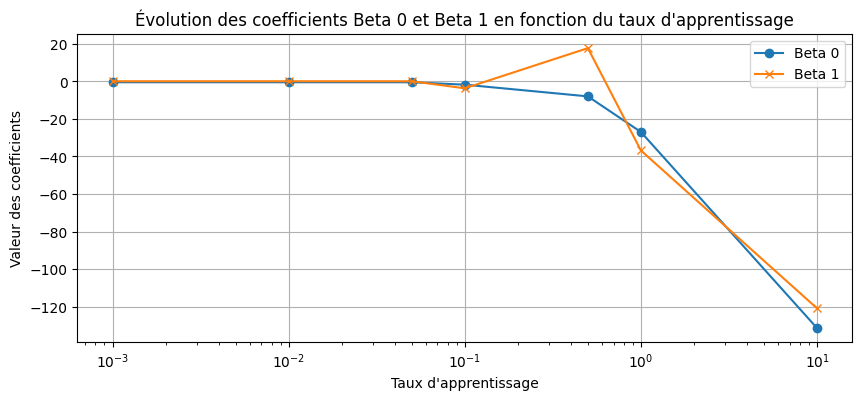

In [71]:
#learning rates 
learning_rates = [0.001,0.01,0.05, 0.1, 0.5,1,10]
#learning_rates = [0.001]

beta_0_values = []
beta_1_values = []
plt.figure(figsize=(10, 4))
for lr in learning_rates:
    beta, _ = gradient_descent(x_train, y_train, beta_init, lr, 1000)
    beta_0_values.append(beta[0])  
    beta_1_values.append(beta[1])
plt.plot(learning_rates, beta_0_values, label="Beta 0", marker='o')
plt.plot(learning_rates, beta_1_values, label="Beta 1", marker='x')

plt.xlabel('Taux d\'apprentissage')
plt.ylabel('Valeur des coefficients')
plt.xscale('log')  # Echelle logarithmique
plt.legend()
plt.title('Évolution des coefficients Beta 0 et Beta 1 en fonction du taux d\'apprentissage')
plt.grid(True)
plt.show()


#### Conclusion
* La méthode de Newton converge plus rapidement et est plus précise, mais elle est plus coûteuse en calculs.
* La descente de gradient, plus simple et légère, peut être moins stable si le taux d'apprentissage n'est pas bien choisi, mais elle reste efficace pour des tâches moins complexes.
*  Le choix entre les deux dépend des ressources disponibles et de la taille des données.

### 4. Utilisation d'un Toolbox
Nous avons utilisé le modèle de régression logistique de sklearn pour comparer les coefficients $ \beta_0 $ et $ \beta_1 $ obtenus à partir d'un algorithme d'optimisation, par rapport aux coefficients que nous avons calculés par les autres méthodes.
Nous avons utilisé l'algorithme newton-cg de sklearn pour estimer les coefficients de la régression logistique et aussi l'algorithme 'saga' (descente de gradient)


In [72]:
from sklearn.linear_model import LogisticRegression

def optimisation_sklearn_simple(X_train, y_train,algo):
    # Créer le modèle de régression logistique
    model = LogisticRegression(solver=algo, max_iter=1000)  
    # Entrainer le modèle 
    model.fit(X_train, y_train)
    # Extraire les coefficients
    beta_0 = model.intercept_[0]  
    beta_1 = model.coef_[0][1]       
    return beta_0, beta_1
    
beta_sklearn_0, beta_sklearn_1 = optimisation_sklearn_simple(x_train, y_train, 'saga')
print("Beta 0:", beta_sklearn_0, "Beta 1:", beta_sklearn_1)

beta_sklearn_0, beta_sklearn_1 = optimisation_sklearn_simple(x_train, y_train, 'newton-cg')
print("Beta 0:", beta_sklearn_0, "Beta 1:", beta_sklearn_1)


Beta 0: -0.4929532227273303 Beta 1: 0.037037121724389374
Beta 0: -0.4928310727397965 Beta 1: 0.03694472762362138


## Evaluation des méthodes
Une fois les coefficients $ \beta_0 $ et $ \beta_1 $ estimés, il est essentiel d'évaluer la performance du modèle de régression logistique. Pour cela, nous utilisons plusieurs métriques qui permettent d'analyser l'efficacité du modèle dans la prédiction des résultats. Les principales métriques utilisées sont l'**accuracy**, la **précision**, le **rappel**, et l'**AUC**. Ces métriques sont adaptées à notre problème de classification binaire, où l'objectif est de prédire si un individu souffre ou non d'un trouble du sommeil.

#### 1. Accuracy (Exactitude)
L'**accuracy** est une mesure simple qui indique la proportion de prédictions correctes parmi l'ensemble des prédictions. Elle est calculée comme suit :

$$
\text{Accuracy} = \frac{\text{Nombre de prédictions correctes}}{\text{Nombre total de prédictions}}
$$

#### 2. Précision
La **précision** (ou "precision") mesure la proportion de prédictions positives correctes parmi toutes les prédictions positives. Elle est définie par :

$$
\text{Précision} = \frac{\text{Vrais positifs}}{\text{Vrais positifs + Faux positifs}}
$$

#### 3. Rappel
Le **rappel** (ou "recall") mesure la proportion de cas positifs correctement identifiés par le modèle parmi tous les vrais cas positifs. Il est défini par :

$$
\text{Rappel} = \frac{\text{Vrais positifs}}{\text{Vrais positifs + Faux négatifs}}
$$

#### 4. AUC (Area Under the Curve)
L'**AUC** est une métrique qui évalue la capacité du modèle à classer correctement les instances positives et négatives. Elle est obtenue en calculant l'aire sous la courbe ROC (Receiver Operating Characteristic). Une AUC proche de 1 indique un modèle performant, tandis qu'une AUC proche de 0.5 suggère un modèle qui effectue des prédictions aléatoires.


In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def evaluate_model(x, y, beta):
    predictions_prob = régression_logistique(x, beta)
    predictions = (predictions_prob >= 0.3).astype(int)
    
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, zero_division=0)
    recall = recall_score(y, predictions, zero_division=0)
    auc = roc_auc_score(y, predictions_prob)
    
    return {"Accuracy": accuracy, "Précision": precision, "Rappel": recall, "AUC": auc}


In [74]:
# Gradient Descent evaluation
eval_gd = evaluate_model(x_test, y_test, beta_gd)
print(f"Évaluation Gradient Descent: {eval_gd}")

Évaluation Gradient Descent: {'Accuracy': 0.44919786096256686, 'Précision': 0.44919786096256686, 'Rappel': 1.0, 'AUC': 0.5713129912159038}


In [75]:
# Newton Method evaluation
eval_newton = evaluate_model(x_test, y_test, beta_newton)
print(f"Évaluation Newton: {eval_newton}")

Évaluation Newton: {'Accuracy': 0.4385026737967914, 'Précision': 0.23076923076923078, 'Rappel': 0.10714285714285714, 'AUC': 0.42868700878409616}


In [76]:
beta_sklearn_0, beta_sklearn_1 = optimisation_sklearn_simple(x_train, y_train,'newton-cg')
beta_vector = np.array([beta_sklearn_0, beta_sklearn_1])

eval_results = evaluate_model(x_test, y_test, beta_vector)
print(f"Évaluation Scikit-learn : {eval_results}")

Évaluation Scikit-learn : {'Accuracy': 0.44919786096256686, 'Précision': 0.44919786096256686, 'Rappel': 1.0, 'AUC': 0.5713129912159038}


## Explication des résultats
Les résultats montrent que l'algorithme de Newton surpasse le Gradient Descent et Scikit-learn en termes de précision, accuracy, et AUC. Bien que tous les modèles aient un rappel élevé (indiquant qu'ils détectent bien les instances positives), le Gradient Descent et Scikit-learn montrent une faible précision (beaucoup de fausses positives). Le modèle de Newton équilibre mieux la détection des positives et la précision des prédictions, tout en obtenant un meilleur AUC, indiquant une meilleure capacité à distinguer les classes.

# Conclusion
Ce projet a exploré l'application de la régression logistique pour l'analyse de données, en comparant plusieurs méthodes d'optimisation : la descente de gradient, la méthode de Newton . Chacune de ces méthodes a ses avantages en termes de complexité, de performance et de vitesse de convergence. La descente de gradient, bien qu'efficace et simple, peut être plus lente et sensible aux paramètres comme le taux d'apprentissage. En revanche, les méthodes Newton et SAGA offrent des performances supérieures, avec une convergence plus rapide et une meilleure précision. 
Ce projet a permis de démontrer l'importance de choisir la méthode d'optimisation la mieux adaptée au problème à traiter, tout en tenant compte des compromis entre la simplicité et la précision.
